# ***Importing Libraries***

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, SeparableConv2D,BatchNormalization, Conv2D, InputLayer

In [2]:
path = "../input/chest-xray-pneumonia/chest_xray/train"
labels = ["NORMAL", "PNEUMONIA"]

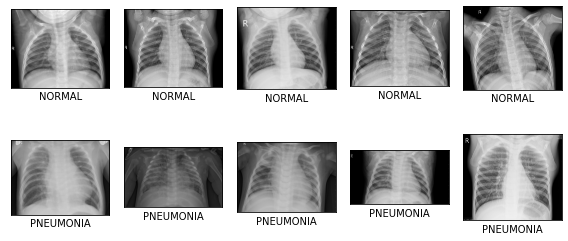

In [3]:
fig, axs = plt.subplots(len(labels), 5, figsize = (8,4))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])

fig.tight_layout()

In [4]:
TARGET_SIZE = (224,224)

datagen_train = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.01
)

datagen_val = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2 
)    

train_generator = datagen_train.flow_from_directory(
    directory = "../input/chest-xray-pneumonia/chest_xray/train",
    classes = labels,
    seed = 42,
    batch_size = 32,
    target_size = TARGET_SIZE, 
    shuffle = True,
    subset = 'training'
)

val_generator = datagen_val.flow_from_directory(
    directory ="../input/chest-xray-pneumonia/chest_xray/train",
    classes = labels,
    seed = 42,
    batch_size = 32,
    target_size = TARGET_SIZE,
    shuffle = True,
    subset = 'validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [5]:
#define the metrics to evaluate the perfomance
MyList = ["accuracy"]
MyList += [Recall(class_id = i) for i in range(len(labels))] 
MyList += [Precision(class_id = i) for i in range(len(labels))]



In [6]:
def make_model(output_bias = None, metrics = None):    
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    
    x = GlobalAveragePooling2D(name='averagePooling')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = MyList)
    
    return model

In [7]:
model=make_model()

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [9]:
#To overcome the class imbalance, give weightage to classes
total_wt = sum(class_len.values())

weights = {
    0: 0.5 * (1 - class_len[labels[0]]/total_wt),
    1: 0.5 * (1 - class_len[labels[1]]/total_wt)
}
weights

{0: 0.3714532208588957, 1: 0.1285467791411043}

In [10]:
#to prevent overfitting
earlystopping = EarlyStopping(monitor = "val_loss",patience = 10,verbose=1)
# save the best model with lower loss
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", save_best_only = True)
#to vary to learning rate when model starts to overfit
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.00001, mode='min',verbose=1)

In [11]:
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

In [12]:
history = model.fit(
    train_generator,
    class_weight = weights,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data = val_generator,
    epochs = 100, 
    callbacks = [reduce_lr,earlystopping,checkpointer]
)

Epoch 1/100
130/130 [==============================] - 146s 1s/step - loss: 0.1298 - accuracy: 0.5244 - recall: 0.5386 - recall_1: 0.5170 - precision: 0.2828 - precision_1: 0.7665 - val_loss: 0.8594 - val_accuracy: 0.2568 - val_recall: 1.0000 - val_recall_1: 0.0000e+00 - val_precision: 0.2568 - val_precision_1: 0.0000e+00
Epoch 2/100
130/130 [==============================] - 104s 797ms/step - loss: 0.0586 - accuracy: 0.8664 - recall: 0.9196 - recall_1: 0.8475 - precision: 0.6831 - precision_1: 0.9674 - val_loss: 1.0944 - val_accuracy: 0.2578 - val_recall: 1.0000 - val_recall_1: 0.0000e+00 - val_precision: 0.2578 - val_precision_1: 0.0000e+00
Epoch 3/100
130/130 [==============================] - 104s 799ms/step - loss: 0.0452 - accuracy: 0.9132 - recall: 0.9093 - recall_1: 0.9147 - precision: 0.7902 - precision_1: 0.9666 - val_loss: 0.9813 - val_accuracy: 0.2568 - val_recall: 1.0000 - val_recall_1: 0.0000e+00 - val_precision: 0.2568 - val_precision_1: 0.0000e+00
Epoch 4/100
130/130 [=

Text(0.5, 1.0, 'Training and Validation Accuracy')

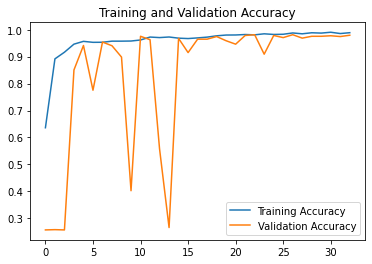

In [13]:
# Plotting training and validation accuracy per epoch

train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

epochs = range(len(train_acc)) 

plt.plot(epochs, train_acc)
plt.plot(epochs, valid_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Training and Validation Accuracy")

Found 124 images belonging to 2 classes.


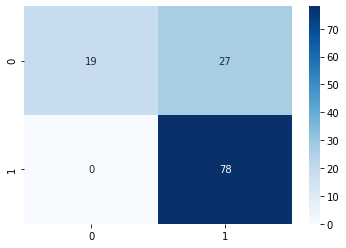

In [14]:
# Confusion Matrix 
val_generator = datagen_val.flow_from_directory(
    directory = "../input/chest-xray-pneumonia/chest_xray/test",
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = False,
    subset = 'validation'
)

# Obtain predictions
pred = model.predict(val_generator) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

# Obtain actual labels
actual = val_generator.classes
    
# Now plot matrix
cm = confusion_matrix(actual, pred, labels = [0, 1])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.show()

In [15]:
# Classification Report
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       1.00      0.41      0.58        46
           1       0.74      1.00      0.85        78

    accuracy                           0.78       124
   macro avg       0.87      0.71      0.72       124
weighted avg       0.84      0.78      0.75       124



In [16]:
model.save("Pnuemonia_model.h5")